In [ ]:
#this version of the program is using presets for the sdAb library

In [ ]:
#This program is used for unpaired read illumina sequencing fastq files.  The goal here is to take in your
#sequencing file, and to cut out reads that match your defined template.  In this case of a synthetic 
#sdAB library we know the exact sequences that should be constant before and after our randomized positions.
#Using the user specified sequences we cut out those sequences and then translate them to AA sequences. 
# please note that the user specified sequences need to be in-frame (all of our mutants are in frame)
from datetime import datetime
from Bio.Seq import Seq
from Bio import SeqIO
import modin.pandas as pd #multithreading version of pandas
from distributed import Client
import os
client = Client()

# Directory containing the .fa files
Output_directory = "Output_Files"
cluster_directory = "Clusters"
# Create the directory folders if it doesn't exist
if not os.path.exists(Output_directory):
    os.makedirs(Output_directory)
if not os.path.exists(cluster_directory):
    os.makedirs(cluster_directory)
# Create the "Logos" folder if it doesn't exist
logos_folder = "Logos"
if not os.path.exists(logos_folder):
    os.makedirs(logos_folder)
# Directory containing the .fa files
Scatterplot_directory = "Scatterplots"

# Create the directory folder if it doesn't exist
if not os.path.exists(Scatterplot_directory):
    os.makedirs(Scatterplot_directory)

def reverse_complement(seq):
    """Return the reverse complement of a DNA sequence"""
    return str(Seq(seq).reverse_complement())


# User-defined sequences in 5' to 3' direction - you can also add other startX and stopXs to the lists
seqs_5to3 = {
    "start1": "GGTGGTTCCCTACGT",
    "stop1": "ACCCAAGTC",
}

# User-defined sequences in 3' to 5' direction - this is the same sequence you put above, just in reverse
seqs_3to5 = {
    "start3": "GACTTGGGT", #this should be the reverse complement of stop 1
    "stop3": "ACGTAGGGAACCACC",#this should be the reverse complement of start1
}

# Convert 3' to 5' sequences to 5' to 3'
seqs_5to3.update(
    {f"{key}_rc": reverse_complement(val) for key, val in seqs_3to5.items()}
)

# Initialize an empty list to store results
results = []

# Iterate over each record in the FASTQ file
for record in SeqIO.parse("Illumina_test_sdAB.fastq", "fastq"):
    # Extract the DNA sequence from the record
    seq = str(record.seq)

    # Iterate over the user-defined sequences
    for seq_key, seq_val in seqs_5to3.items():
        # Find the start and end indices of the sequence of interest
        start_index = seq.find(seq_val)
        end_index = seq.find(seqs_5to3[f"{seq_key.replace('start', 'stop')}"], start_index + len(seq_val))

        # Check if the sequence of interest was found
        if start_index != -1 and end_index != -1:
            # Extract the DNA sequence between the start and stop sequences
            dna_seq = seq[start_index + len(seq_val): end_index]

            # Reverse complement the DNA sequence if the user-defined sequence was in the 3' to 5' direction
            if seq_key.endswith("_rc"):
                dna_seq = reverse_complement(dna_seq)

            # Translate the DNA sequence to amino acids
            aa_seq = Seq(dna_seq).translate()

            # Add the result to the list of results
            results.append({"Sequence": aa_seq, "KD": "1"}) #this is where we will have to add KDs from TITEseq someday

# Convert the results to a pandas DataFrame and write to an Excel file

df = pd.DataFrame(results)
df.to_excel("Output_Files/output-sdab-clusters.xlsx", index=False)

In [ ]:
#this works, just has the future warning
import matplotlib.pyplot as plt
import Levenshtein as lev
from matplotlib.pyplot import figure
from sklearn.cluster import DBSCAN
from Levenshtein import distance
from scipy.spatial.distance import cdist
import numpy as np
from distributed import Client
client = Client()
import modin.pandas as pd
# Define the framework sequences
frameworks = {
    'Framework1': 'LSCAAS',  #original value  'LSCAAS'
    'Framework2': 'GWYRQAPGKER', #original value 'GWYRQAPGKER'
    'Framework3': 'ADSVKGRFTISRDNAKNTVYLQMNSLKPEDTAVYYC',  #original value 'ADSVKGRFTISRDNAKNTVYLQMNSLKPEDTAVYYC'
    'Framework4': 'YWGQG',     #original value 'YWGQG'
}

# Define the CDR loop positions relative to the framework sequences
cdr_positions = {
    'CDR1': ['Framework1', 'Framework2'],
    'CDR2': ['Framework2', 'Framework3'], 
    'CDR3': ['Framework3', 'Framework4'],
}

# Load the data from the Excel file
print("Reading CSV")
df = pd.read_csv('NSG_miseq_F_top200.csv')
print("Starting Number of sequences ", len(df))
print("Deleting sequences that do not contain one of the intended frameworks")
strings_to_check = {'LSCAAS', 'GWYRQAPGKER', 'ADSVKGRFTISRDNAKNTVYLQMNSLKPEDTAVYYC', 'YWGQG'}
df['Sequence'] = df['Sequence'].str.strip()
print("Remaining Sequences ",len(df))
# Remove lines containing the asterisk character
pd.set_option('display.max_rows', 2000)
print(df)
print("Removing sequences with stop codons")
df = df[~df.astype(str).apply(lambda x: x.str.contains('\\*')).any(axis=1)]
print("Remaining Sequences ",len(df))
# Check if all strings in `strings_to_check` are present in the 'Sequence' column
df = df[df['Sequence'].apply(lambda x: all(string in x for string in strings_to_check))]
print("Assigning random numbers to the KD column- Only use this if you have no TITE-seq values")
df['KD'] = np.random.randint(1, 1001, size=len(df))
pd.set_option('display.max_rows', 2000)
print(df)


In [ ]:
# Extract the CDR loop sequences
import collections
print("Extracting CDR Loops")
cdr_seqs = {}
for cdr, positions in cdr_positions.items():
    start, end = positions
    cdr_seqs[cdr] = [seq[seq.find(frameworks[start])+len(frameworks[start]):seq.find(frameworks[end])] for seq in df['Sequence']]
print("Number of cdr_seqs ",len(cdr_seqs),":")
print(cdr_seqs)
# Calculate the frequency percentage of each CDR sequence as a percentage
cdr_freqs = {}
print("Calculating CDR Frequencies")
for cdr in cdr_seqs:
    cdr_count = len(cdr_seqs[cdr])
    cdr_seq_array = np.array(cdr_seqs[cdr])
    seq_counts = collections.Counter(cdr_seq_array)
    cdr_freqs[cdr] = [((count / cdr_count)* 100) for _, count in seq_counts.items()]
print("CDR FREQs loop result")
print(cdr_freqs)
print("CDR seq array")
print(cdr_seq_array)
# Find the most common CDR sequence for each loop
cdr_consensus_seqs = {}
print("Identifying the most common CDR sequences for each loop")
for cdr in cdr_seqs:
    cdr_freq_array = np.array(cdr_freqs[cdr])
    max_freq_idx = np.argmax(cdr_freq_array)
    cdr_consensus_seqs[cdr] = cdr_seqs[cdr][max_freq_idx]

# Calculate the Levenshtein distance between each CDR sequence and the consensus sequence
print("Calculating Levenshtein distance between each CDR and the most common CDR")
cdr_distances = {}
for cdr in cdr_seqs:
    cdr_distances[cdr] = [lev.distance(seq, cdr_consensus_seqs[cdr]) for seq in cdr_seqs[cdr]]

# Create a new dataframe with the results, removing duplicate sequences
print("Combining data to a single dataframe")
print(df)
print("Dropping sequences that don't have CDR sequences")
df = df.dropna()
print(df)
# cdr_df = pd.DataFrame()
# min_length = min(len(df), len(cdr_seqs['CDR1']), len(cdr_freqs['CDR1']), len(cdr_distances['CDR1']), len(cdr_seqs['CDR2']), len(cdr_freqs['CDR2']), len(cdr_distances['CDR2']), len(cdr_seqs['CDR3']), len(cdr_freqs['CDR3']), len(cdr_distances['CDR3']))
# for i in range(min_length):
#     cdr_df = pd.concat([cdr_df, pd.DataFrame({'Sequence': df['Sequence'].iloc[i],
#                                        'KD': df['KD'].iloc[i],
#                                        'CDR1 Seq': cdr_seqs['CDR1'][i],
#                                        'CDR1 Freq': cdr_freqs['CDR1'][i],
#                                        'CDR1 Distance': cdr_distances['CDR1'][i],
#                                        'CDR2 Seq': cdr_seqs['CDR2'][i],
#                                        'CDR2 Freq': cdr_freqs['CDR2'][i],
#                                        'CDR2 Distance': cdr_distances['CDR2'][i],
#                                        'CDR3 Seq': cdr_seqs['CDR3'][i],
#                                        'CDR3 Freq': cdr_freqs['CDR3'][i],
#                                        'CDR3 Distance': cdr_distances['CDR3'][i]}, index=[i])],
#                         ignore_index=True)
# import collections

# # ...

# Calculate the frequency percentage of each CDR sequence as a percentage
print("Calculating CDR Frequencies")
for cdr in cdr_seqs:
    cdr_count = len(cdr_seqs[cdr])
    cdr_seq_array = np.array(cdr_seqs[cdr])
    seq_counts = collections.Counter(cdr_seq_array)
    df[f'{cdr} Seq'] = pd.Series(cdr_seq_array)
    df[f'{cdr} Freq'] = pd.Series([((count / cdr_count)* 100) for _, count in seq_counts.items()])

# Calculate the Levenshtein distance between each CDR sequence and the consensus sequence
print("Calculating Levenshtein distance between each CDR and the most common CDR")
for cdr in cdr_seqs:
    df[f'{cdr} Distance'] = pd.Series([lev.distance(seq, cdr_consensus_seqs[cdr]) for seq in cdr_seqs[cdr]])

# ...


print("Number of sequences after CDR1, CDR2, and CDR3 Extraction ", len(df) )



In [ ]:
pd.set_option('display.max_rows', 2000)
df['CDR1 Freq'] = (df['CDR1 Seq'].value_counts(normalize=True)* 100)
df

In [ ]:
print("Removing duplicated full sequences")
cdr_df = cdr_df.drop_duplicates(subset=['Sequence'])
print("Number of sequences after dropping duplicated full sequences ", len(cdr_df))
#cdr_df[['Sequence Freq']] = cdr_df[['Sequence Freq']].apply(lambda x: round(x, 2))
cdr_df[['CDR1 Freq']] = cdr_df[['CDR1 Freq']].apply(lambda x: round(x, 2))
cdr_df[['CDR2 Freq']] = cdr_df[['CDR2 Freq']].apply(lambda x: round(x, 2))
cdr_df[['CDR3 Freq']] = cdr_df[['CDR3 Freq']].apply(lambda x: round(x, 2))

print(cdr_df)
# Define a function to compute the pairwise distance matrix between all sequences
#def pairwise_distance_matrix(sequences):
#    n = len(sequences)
#    dist_matrix = np.zeros((n, n))
#    for i in range(n):
#        for j in range(i+1, n):
#            dist_matrix[i, j] = distance(sequences[i], sequences[j])
#            dist_matrix[j, i] = dist_matrix[i, j]
#    return dist_matrix

# Compute the pairwise distance matrix - might need something here
print("Computing Distance Matrix (Levenshtein) for Full Sequence")
sequences = cdr_df['Sequence'].tolist()
dist_matrix = np.zeros((len(sequences), len(sequences)))
for i in range(len(sequences)):
    for j in range(i+1, len(sequences)):
        dist_matrix[i, j] = lev.distance(sequences[i], sequences[j])
        dist_matrix[j, i] = dist_matrix[i, j]

#dist_matrix = pairwise_distance_matrix(cdr_df['Sequence'].values)
#dist_matrix = pairwise_distance_matrix(cdr_df['CDR1 Seq'].values)
#dist_matrix = pairwise_distance_matrix(cdr_df['CDR2 Seq'].values)
#dist_matrix = pairwise_distance_matrix(cdr_df['CDR3 Seq'].values)

print(dist_matrix)
# Run DBSCAN on the distance matrix
dbscan = DBSCAN(metric='precomputed', eps=1.5, min_samples=2)
dbscan.fit(dist_matrix)

# Extract the cluster labels
cluster_labels = dbscan.labels_

# Print the number of clusters found
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print('Number of clusters found:', n_clusters)

# Add the cluster labels to the dataframe
cdr_df['Sequence Cluster'] = cluster_labels

print("Computing Distance Matrix (Levenshtein) for CDR1")
sequences = cdr_df['CDR1 Seq'].tolist()
dist_matrix = np.zeros((len(sequences), len(sequences)))
for i in range(len(sequences)):
    for j in range(i+1, len(sequences)):
        dist_matrix[i, j] = lev.distance(sequences[i], sequences[j])
        dist_matrix[j, i] = dist_matrix[i, j]

# Run DBSCAN on the distance matrix
dbscan = DBSCAN(metric='precomputed', eps=0.5, min_samples=2)
dbscan.fit(dist_matrix)

# Extract the cluster labels
cluster_labels = dbscan.labels_
cdr_df['CDR1 Cluster'] = cluster_labels
# Print the number of clusters found
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print('Number of clusters found for CDR1:', n_clusters)


print("Computing Distance Matrix (Levenshtein) for CDR2")
sequences = cdr_df['CDR2 Seq'].tolist()
dist_matrix = np.zeros((len(sequences), len(sequences)))
for i in range(len(sequences)):
    for j in range(i+1, len(sequences)):
        dist_matrix[i, j] = lev.distance(sequences[i], sequences[j])
        dist_matrix[j, i] = dist_matrix[i, j]
# Run DBSCAN on the distance matrix
dbscan = DBSCAN(metric='precomputed', eps=1.0, min_samples=2)
dbscan.fit(dist_matrix)

# Extract the cluster labels
cluster_labels = dbscan.labels_
cdr_df['CDR2 Cluster'] = cluster_labels
# Print the number of clusters found
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print('Number of clusters found for CDR2:', n_clusters)
        
cdr_df['CDR2 Cluster'] = cluster_labels

print("Computing Distance Matrix (Levenshtein) for CDR3")
sequences = cdr_df['CDR3 Seq'].tolist()
dist_matrix = np.zeros((len(sequences), len(sequences)))
for i in range(len(sequences)):
    for j in range(i+1, len(sequences)):
        dist_matrix[i, j] = lev.distance(sequences[i], sequences[j])
        dist_matrix[j, i] = dist_matrix[i, j]
# Run DBSCAN on the distance matrix
dbscan = DBSCAN(metric='precomputed', eps=1.0, min_samples=2)
dbscan.fit(dist_matrix)

# Extract the cluster labels
cluster_labels = dbscan.labels_
cdr_df['CDR2 Cluster'] = cluster_labels
# Print the number of clusters found
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print('Number of clusters found for CDR3:', n_clusters)
        
cdr_df['CDR3 Cluster'] = cluster_labels
print(cdr_df)
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import modin.pandas as pd

# Define a function to calculate GRAVY and pI
def calculate_gravy_and_pi(seq):
    # Create a ProteinAnalysis object for the amino acid sequence
    protein = ProteinAnalysis(seq)
    
    # Calculate GRAVY
    gravy = protein.gravy()
    
    # Calculate pI
    pi = protein.isoelectric_point()
    
    return gravy, pi

# Apply the function to the 'CDR1 Seq' column and store the results in new columns
print("Calculating Gravy and pI")
cdr_df[['GRAVY_Index', 'pI']] = pd.DataFrame(cdr_df['CDR1 Seq'].apply(calculate_gravy_and_pi).tolist(), index=cdr_df.index)
cdr_df[['GRAVY_Index', 'pI']] = pd.DataFrame(cdr_df['CDR2 Seq'].apply(calculate_gravy_and_pi).tolist(), index=cdr_df.index)
cdr_df[['GRAVY_Index', 'pI']] = pd.DataFrame(cdr_df['CDR3 Seq'].apply(calculate_gravy_and_pi).tolist(), index=cdr_df.index)



cdr_df = cdr_df.reset_index(drop=True)
# Save the results to a new Excel file
print("Printing Output_Files/sdAB_distances.xlsx")
cdr_df.to_excel('Output_Files/sdAB_distances.xlsx', index=False)

# Create scatterplots for each CDR loop
print("Output Excel Created")
for cdr in cdr_distances:
    plt.scatter(cdr_df['CDR1 Distance'], cdr_df['KD'], c=cluster_labels)
    plt.xlabel('Levenshtein Distance from Most Common Sequence for '+cdr)
    plt.ylabel('KD')
    plt.title("Distances vs KD for "+cdr)
    for i, seq in enumerate(cdr_seqs[cdr]):
        plt.annotate(seq, (cdr_distances[cdr][i], df['KD'][i]))
    plt.savefig('Scatterplots/Scatter_with_sequences.png', dpi=300)
    plt.show()
print("Output Scatterplot for Lev Distance vs KD")    
for cdr in cdr_distances:
    plt.scatter(cdr_df['CDR1 Distance'], cdr_df['KD'], c=cluster_labels)
    plt.xlabel('Levenshtein Distance from Most Common Sequence for '+cdr)
    plt.ylabel('KD')
    plt.title("Distances vs KD for "+cdr)
    plt.savefig('Scatterplots/Scatter_only_KD_distance.png', dpi=300)
    plt.show()
print("Output Scatterplot for Lev Distance vs KD")
for cdr in cdr_distances:
    plt.scatter(cdr_df['CDR1 Distance'], cdr_df['GRAVY_Index'], c=cluster_labels)
    plt.xlabel('Levenshtein Distance from Most Common Sequence for '+cdr)
    plt.ylabel('GRAVY Index')
    plt.title("Distances vs GRAVY Index for "+cdr)
    plt.savefig('Scatterplots/Scatter_only_GRAVY_distance.png', dpi=300)
    plt.show()
print("Output Scatterplot for Lev Distance vs GRAVY Index")
for cdr in cdr_distances:
    plt.scatter(cdr_df['CDR1 Distance'], cdr_df['pI'], c=cluster_labels)
    plt.xlabel('Levenshtein Distance from Most Common Sequence for '+cdr)
    plt.ylabel('pI')
    plt.title("Distances vs pI for "+cdr)
    plt.savefig('Scatterplots/Scatter_only_pI_distance.png', dpi=300)
    plt.show()
print("Output Scatterplot for Lev Distance vs pI")

In [ ]:
#this is how you choose an eps value for dbscan
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Assuming 'cdr_df' is your dataframe and 'CDR2 Distance' is the column name
X = cdr_df['CDR3 Distance'].values.reshape(-1, 1)

# Calculate k-distance graph
k = 4  # Choose the desired value of k
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, indices = nbrs.kneighbors(X)

# Sort distances in descending order
k_distances = np.sort(distances[:, -1])[::-1]

# Plot k-distance graph
plt.plot(np.arange(1, len(X)+1), k_distances,marker='o', linestyle='-', color='blue')
plt.xlabel('Data Points')
plt.ylabel(f'{k}-Distance')
plt.title(f'K-Distance Plot (k={k})')
plt.show()


In [ ]:
plt.ioff()

for cdr in cdr_distances:
    # Create a scatter plot directly from the dataframe
    cdr_df.plot.scatter(x='CDR1 Distance', y='KD', c=cluster_labels, title="Distances vs KD for " + cdr)

    # Add annotations to the plot
    for i, seq in enumerate(cdr_seqs[cdr]):
        plt.annotate(seq, (cdr_distances[cdr][i], df['KD'][i]))

    # Save the figure
    plt.savefig('Scatterplots/Scatter_with_sequences_' + cdr + '.png', dpi=300)

    # Clear the current plot
    plt.clf()

# Show the plots if needed
plt.show()


In [ ]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO
import modin.pandas as pd

# Read the amino acid sequences from the CDR1 Seq column of the dataframe
sequences = [SeqRecord(Seq(seq), id=str(i+1)) for i, seq in enumerate(cdr_df['CDR1 Seq'])]

# Align the sequences
alignment = MultipleSeqAlignment(sequences)

# Write the aligned sequences to a file in FASTA format
with open('Clusters/cdr1_global_alignment.fa', 'w') as f:
    AlignIO.write(alignment, f, 'fasta')
print("Global alignment completed")

In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

# Read the sequences from the DataFrame
cdr_sequences = cdr_df['CDR1 Seq'].tolist()

# Group sequences by cluster
groups = cdr_df.groupby('Cluster')
for cluster, group in groups:
    # Create a list of SeqRecord objects
    seq_records = []
    for i, seq in enumerate(group['CDR1 Seq']):
        seq_record = SeqRecord(Seq(seq), id=f'seq{i+1}')
        seq_records.append(seq_record)
    
    # Align the sequences
    alignment = MultipleSeqAlignment(seq_records)
    
    # Write the aligned sequences to a file in FASTA format
    with open(f'Clusters/cdr1_alignment_{cluster}.fa', 'w') as f:
        SeqIO.write(alignment, f, 'fasta')
print("CDR1 Cluster sequence alignment completed")

In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

# Read the sequences from the DataFrame
cdr_sequences = cdr_df['CDR2 Seq'].tolist()

# Group sequences by cluster
groups = cdr_df.groupby('Cluster')
for cluster, group in groups:
    # Create a list of SeqRecord objects
    seq_records = []
    for i, seq in enumerate(group['CDR2 Seq']):
        seq_record = SeqRecord(Seq(seq), id=f'seq{i+1}')
        seq_records.append(seq_record)
    
    # Align the sequences
    alignment = MultipleSeqAlignment(seq_records)
    
    # Write the aligned sequences to a file in FASTA format
    with open(f'Clusters/cdr2_alignment_{cluster}.fa', 'w') as f:
        SeqIO.write(alignment, f, 'fasta')
print("CDR2 Cluster sequence alignment completed")

In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

# Read the sequences from the DataFrame
cdr_sequences = cdr_df['CDR3 Seq'].tolist()

# Group sequences by cluster
groups = cdr_df.groupby('Cluster')
for cluster, group in groups:
    # Create a list of SeqRecord objects
    seq_records = []
    for i, seq in enumerate(group['CDR3 Seq']):
        seq_record = SeqRecord(Seq(seq), id=f'seq{i+1}')
        seq_records.append(seq_record)
    
    # Align the sequences
    alignment = MultipleSeqAlignment(seq_records)
    
    # Write the aligned sequences to a file in FASTA format
    with open(f'Clusters/cdr3_alignment_{cluster}.fa', 'w') as f:
        SeqIO.write(alignment, f, 'fasta')
print("CDR2 Cluster sequence alignment completed")

In [ ]:
#this just makes one logo
import logomaker
from Bio import AlignIO

# Read in the alignment file in FASTA format
alignment = AlignIO.read("Clusters/cdr1_alignment_0.fa", "fasta")

# Convert the alignment to a list of sequences
sequences = [str(record.seq) for record in alignment]

# Convert the sequences to a pandas dataframe
alignment_df = logomaker.alignment_to_matrix(sequences)

# Create the sequence logo
logo = logomaker.Logo(alignment_df, color_scheme='dmslogo_funcgroup')
# Customize the logo appearance
logo.style_spines(visible=False)
logo.ax.xaxis.set_tick_params(labelsize=8, which='major', pad=0)
logo.ax.xaxis.set_tick_params(labelsize=0, which='minor', pad=0)
logo.ax.xaxis.set_major_locator(plt.MultipleLocator(1))
logo.ax.set_title("CDR1 Logo", fontsize=18)
# Save the figure as a PDF file
logo_fig = logo.fig
logo_fig.savefig('Logos/CDR1_logo.png', dpi=300)

In [ ]:
#for outputting every logo in the folder
import os
import logomaker
from Bio import AlignIO
directory = "Clusters"
logos_folder = "Logos"
if not os.path.exists(logos_folder):
    os.makedirs(logos_folder)

# Get a list of .fa files in the directory
fa_files = [file for file in os.listdir(directory) if file.startswith("cdr") and file.endswith(".fa")]

# Process each .fa file
for fa_file in fa_files:
    # Extract the varying part of the file name
    varying_part = fa_file[len("cdr1_alignment_"):-len(".fa")]

    # Read in the alignment file in FASTA format
    alignment = AlignIO.read(os.path.join(directory, fa_file), "fasta")

    # Convert the alignment to a list of sequences
    sequences = [str(record.seq) for record in alignment]

    # Convert the sequences to a pandas dataframe
    alignment_df = logomaker.alignment_to_matrix(sequences)

    # Create the sequence logo
    logo = logomaker.Logo(alignment_df, color_scheme='dmslogo_funcgroup')
    # Customize the logo appearance
    logo.style_spines(visible=False)
    logo.ax.xaxis.set_tick_params(labelsize=8, which='major', pad=0)
    logo.ax.xaxis.set_tick_params(labelsize=0, which='minor', pad=0)
    logo.ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    logo.ax.set_title(fa_file, fontsize=18)


    # Generate the output file name based on the varying part of the input file name
    output_file = os.path.join(logos_folder, f"logo_{varying_part}.png")

    # Save the figure as a PNG file
    logo_fig = logo.fig
    logo_fig.savefig(output_file, dpi=300)


In [ ]:
print(cdr_df)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = cdr_df

parallel_df = pd.DataFrame({'CDR1 Seq': df['CDR1 Seq'],'CDR2 Seq':df['CDR2 Seq'], 'CDR3 Seq':df['CDR3 Seq'],'KD': df['KD']})

split_seqs = parallel_df['CDR1 Seq'].apply(list).apply(pd.Series)
split_seqs.columns = [f'CDR1.{i+1}' for i in range(split_seqs.shape[1])]


cdr2_seqs = parallel_df['CDR2 Seq'].apply(list).apply(pd.Series)
cdr2_seqs = cdr2_seqs.fillna('Del')
cdr2_seqs.columns = [f'CDR2.{i+1}' for i in range(cdr2_seqs.shape[1])]

cdr3_seqs = parallel_df['CDR3 Seq'].apply(list).apply(pd.Series)
cdr3_seqs = cdr3_seqs.fillna('Del')
cdr3_seqs.columns = [f'CDR3.{i+1}' for i in range(cdr3_seqs.shape[1])]

split_seqs = pd.concat([split_seqs, cdr2_seqs], axis=1)
split_seqs = pd.concat([split_seqs, cdr3_seqs], axis=1)
split_seqs = split_seqs.fillna('Del')

# Define a dictionary to map amino acids to numeric codes
amino_acid_codes = {
    'R': 1,
    'H': 2,
    'K': 3,
    'Del': 4,
    'A': 5,
    'V': 6,
    'I': 7,
    'L': 8,
    'M': 9,
    'F': 10,
    'Y': 11,
    'W': 12,
    'S': 13,
    'T': 14,
    'N': 15,
    'Q': 16,
    'C': 17,
    'G': 18,
    'P': 19,
    'E': 20,
    'D': 21
}

# Convert amino acids to numeric codes
split_seqs = split_seqs.replace(amino_acid_codes)

split_seqs = split_seqs.assign(KD=cdr_df['KD'])

MinKD= min(cdr_df['KD'])
MaxKD= max(cdr_df['KD'])
print("Minimum KD ")
print(MinKD)
print("Maximum KD ")
print(MaxKD)
split_seqs = split_seqs.assign(Cluster=cdr_df['Cluster'])
MaxClusters= max(cdr_df['Cluster'])
MinClusters= min(cdr_df['Cluster'])
print("Number of Clusters Found")
print(abs(MaxClusters-MinClusters)+1)


In [ ]:
import pandas as pd
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

amino_acids = ['R', 'H', 'K', 'DEL', 'A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'S', 'T', 'N', 'Q', 'C', 'G', 'P', 'E', 'D']

dimensions = []

for col in split_seqs.columns:  #this works with any number of CDR residue numbers
    if col.startswith('CDR'):
        dimension = dict(range=[1, 21],
                         label=col,
                         values=split_seqs[col],
                         tickvals=list(range(1, 22)),
                         ticktext=amino_acids)
        dimensions.append(dimension)
    if col.startswith('KD'):
        KD_dimension = dict(range=[MinKD,MaxKD],
                        label=col,
                         values=split_seqs[col])
        dimensions.append(KD_dimension)
    if col.startswith('Cluster'):
        KD_dimension = dict(range=[MinClusters,MaxClusters],
                        label=col,
                         values=split_seqs[col])
        dimensions.append(KD_dimension)
fig = go.Figure(data=go.Parcoords(
    line=dict(color=split_seqs['CDR1.1'],
              colorscale='Jet',
              showscale=False,
              cmin=1,
              cmax=21),
    dimensions=dimensions
))

fig.update_layout(
    title="Hit sdAb CDR Sequences",
    width=2100,
    height=600,
    font=dict(size=14)
)
plotly.io.write_html(fig, include_plotlyjs=True, file='Output_Files/parallel_coordinates_plot.html')
pyo.iplot(fig, filename='Output_Files/parallel_coordinates_plot.html')


In [ ]:
cdr_df

In [ ]:
print(split_seqs)

In [ ]:
import pandas as pd
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import os



amino_acids = ['R', 'H', 'K', 'DEL', 'A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'S', 'T', 'N', 'Q', 'C', 'G', 'P', 'E', 'D']

dimensions = []

for col in split_seqs.columns:
    if col.startswith('CDR'):
        dimension = dict(range=[1, 21],
                         label=col,
                         values=split_seqs[col],
                         tickvals=list(range(1, 22)),
                         ticktext=amino_acids)
        dimensions.append(dimension)
    elif col.startswith('KD'):
        KD_dimension = dict(range=[MinKD, MaxKD],
                            label=col,
                            values=split_seqs[col])
        dimensions.append(KD_dimension)
    elif col.startswith('Cluster'):
        Cluster_dimension = dict(range=[MinClusters, MaxClusters],
                                label=col,
                                values=split_seqs[col])
        dimensions.append(Cluster_dimension)

fig = go.Figure(data=go.Parcoords(
    line=dict(color='blue',
              colorscale='Jet',
              showscale=False,
              cmin=1,
              cmax=21),
    dimensions=dimensions
))

fig.update_layout(
    title="Hit sdAb CDR Sequences",
    width=1900,
    height=600,
    font=dict(size=14)
)

print(os.getcwd())

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id='parallel-coordinates-plot', figure=fig),
    html.Button('Export to Excel', id='export-button'),
])

@app.callback(Output('export-button', 'download'), 
              [Input('export-button', 'n_clicks'), 
               Input('parallel-coordinates-plot', 'selectedData')],
              [State('parallel-coordinates-plot', 'data')])
def export_to_excel(n_clicks, selected_data, parallel_coordinates_data):
    print('n_clicks:', n_clicks)
    print(os.getcwd())
    if n_clicks is not None and selected_data is not None:
        selected_lines = selected_data['lines']
        selected_indices = []
        for line in selected_lines:
            selected_indices.extend(line['pointIndex'])
        
        split_seqs = pd.DataFrame(parallel_coordinates_data['dimensions'][0]['values'])
        selected_rows = split_seqs.iloc[selected_indices]
        print('Number of selected rows:', len(selected_rows))
        selected_rows.to_csv('selected_lines.csv', index=False)
        print("Selected rows exported")
        return 'selected_lines.xlsx'

if __name__ == '__main__':
    app.run_server()


In [ ]:
#this works, just has the future warning - whole thing for vox
import matplotlib.pyplot as plt
import Levenshtein as lev
from matplotlib.pyplot import figure
from sklearn.cluster import DBSCAN
from Levenshtein import distance
from scipy.spatial.distance import cdist
import numpy as np
from distributed import Client
client = Client()
import modin.pandas as pd
# Define the framework sequences
frameworks = {
    'Framework1': 'LSCAAS',  #original value  'LSCAAS'
    'Framework2': 'GWYRQAPGKER', #original value 'GWYRQAPGKER'
    'Framework3': 'ADSVKGRFTISRDNAKNTVYLQMNSLKPEDTAVYYC',  #original value 'ADSVKGRFTISRDNAKNTVYLQMNSLKPEDTAVYYC'
    'Framework4': 'YWGQG',     #original value 'YWGQG'
}

# Define the CDR loop positions relative to the framework sequences
cdr_positions = {
    'CDR1': ['Framework1', 'Framework2'],
    'CDR2': ['Framework2', 'Framework3'], 
    'CDR3': ['Framework3', 'Framework4'],
}

# Load the data from the CSV file
print("Reading CSV")
df = pd.read_csv('NSG_miseq_F_top200.csv')
print("Starting Number of sequences ", len(df))
print("Deleting sequences that do not contain one of the intended frameworks")
strings_to_check = {'LSCAAS', 'GWYRQAPGKER', 'ADSVKGRFTISRDNAKNTVYLQMNSLKPEDTAVYYC', 'YWGQG'}
df['Sequence'] = df['Sequence'].str.strip()
print("Remaining Sequences ",len(df))
# Remove lines containing the asterisk character
print("Removing sequences with stop codons")
df = df[~df.astype(str).apply(lambda x: x.str.contains('\\*')).any(axis=1)]
print("Remaining Sequences ",len(df))
# Check if all strings in `strings_to_check` are present in the 'Sequence' column
df = df[df['Sequence'].apply(lambda x: all(string in x for string in strings_to_check))]
print("Assigning random numbers to the KD column- Only use this if you have no TITE-seq values")
df['KD'] = np.random.randint(1, 1001, size=len(df))
print(df)
# Extract the CDR loop sequences
print("Extracting CDR Loops")
cdr_seqs = {}

# Loop over cdrs only once
for cdr, positions in cdr_positions.items():
    start_framework, end_framework = positions
    # Use a lambda function to extract the CDR sequences
    df[f'{cdr} Seq'] = df['Sequence'].apply(lambda x: x[x.find(frameworks[start_framework])+len(frameworks[start_framework]):x.find(frameworks[end_framework])])

# Calculate the frequency of each CDR sequence and map these frequencies to the corresponding Seq column
for cdr in cdr_positions.keys():
    cdr_freqs = (df[f'{cdr} Seq'].value_counts(normalize=True)* 100)
    df[f'{cdr} Freq'] = df[f'{cdr} Seq'].map(cdr_freqs)

print("printing df after cdr seqs")
print(df)
# Calculate the frequency percentage of each CDR sequence as a percentage
cdr_freqs = {}
print("Calculating CDR Frequencies")
for cdr in cdr_seqs:
    cdr_count = len(cdr_seqs[cdr])
    cdr_seq_array = np.array(cdr_seqs[cdr])
    unique_seqs, counts = np.unique(cdr_seq_array, return_counts=True)
    cdr_freqs[cdr] = (counts / cdr_count)*100
print("CDR FREQs loop result")
print(cdr_freqs)
print("Printing df after cdr freqs")
print(df)
# Find the most common CDR sequence for each loop
cdr_consensus_seqs = {}
print("Identifying the most common CDR sequences for each loop")
for cdr in cdr_seqs:
    cdr_freq_array = np.array(cdr_freqs[cdr])
    max_freq_idx = np.argmax(cdr_freq_array)
    cdr_consensus_seqs[cdr] = cdr_seqs[cdr][max_freq_idx]
print("Printing freq array")
print(cdr_freq_array)
print("Consensus seq loop result")
print(cdr_consensus_seqs)
# Calculate the Levenshtein distance between each CDR sequence and the consensus sequence
print("Calculating Levenshtein distance between each CDR and the most common CDR")
cdr_distances = {}
for cdr in cdr_seqs:
    cdr_distances[cdr] = [lev.distance(seq, cdr_consensus_seqs[cdr]) for seq in cdr_seqs[cdr]]
print("Distance from consensus CDR result:")
print(cdr_distances)
# Create a new dataframe with the results, removing duplicate sequences
print("Combining data to a single dataframe")

cdr_df = pd.DataFrame()
min_length = min(len(df), len(cdr_seqs['CDR1']), len(cdr_freqs['CDR1']), len(cdr_distances['CDR1']), len(cdr_seqs['CDR2']), len(cdr_freqs['CDR2']), len(cdr_distances['CDR2']), len(cdr_seqs['CDR3']), len(cdr_freqs['CDR3']), len(cdr_distances['CDR3']))
for i in range(min_length):
    cdr_df = pd.concat([cdr_df, pd.DataFrame({'Sequence': df['Sequence'].iloc[i],
                                       'KD': df['KD'].iloc[i],
                                       'CDR1 Seq': cdr_seqs['CDR1'][i],
                                       'CDR1 Freq': cdr_freqs['CDR1'][i],
                                       'CDR1 Distance': cdr_distances['CDR1'][i],
                                       'CDR2 Seq': cdr_seqs['CDR2'][i],
                                       'CDR2 Freq': cdr_freqs['CDR2'][i],
                                       'CDR2 Distance': cdr_distances['CDR2'][i],
                                       'CDR3 Seq': cdr_seqs['CDR3'][i],
                                       'CDR3 Freq': cdr_freqs['CDR3'][i],
                                       'CDR3 Distance': cdr_distances['CDR3'][i]}, index=[i])],
                        ignore_index=True)

print("Number of sequences after CDR1, CDR2, and CDR3 Extraction ", len(cdr_df) )
print(cdr_df)


C:\ANACONDA3\lib\site-packages\distributed\node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59411 instead
  f"Port {expected} is already in use.\n"


Reading CSV
Starting Number of sequences  582750
Deleting sequences that do not contain one of the intended frameworks
Remaining Sequences  582750
Removing sequences with stop codons
Remaining Sequences  433936
Assigning random numbers to the KD column- Only use this if you have no TITE-seq values
Extracting CDR Loops
Calculating losses in percentage on each step
                     Step   Count Percent of Initial
0                   Start  582750              100.0
1       1 Framework Check  582750              100.0
2    Removing Stop Codons  433936          74.463492
3     All Framework Check  406621          69.776233
4  Framework Length Check  404635          69.435435
writing df to csv
Graphing loss of sequences from filtering


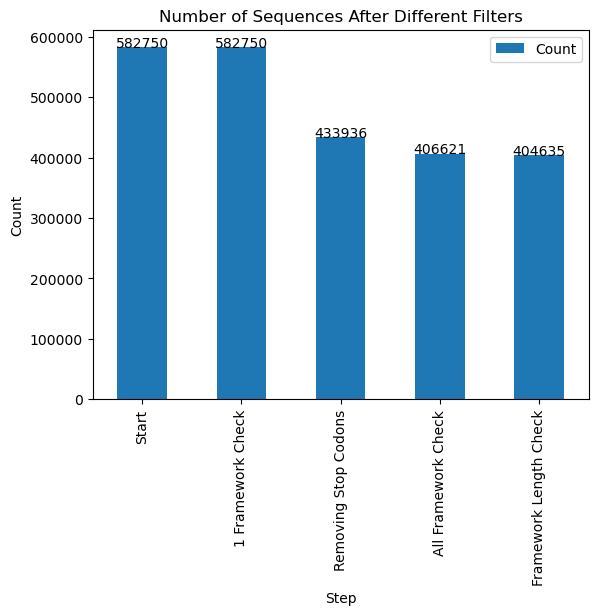

Completed


In [21]:
#this works, just has the future warning this is the latesworkingone
import matplotlib.pyplot as plt
import Levenshtein as lev
from matplotlib.pyplot import figure
from sklearn.cluster import DBSCAN
from Levenshtein import distance
from scipy.spatial.distance import cdist
import numpy as np
from distributed import Client
client = Client()
import pandas as pd
# Define the framework sequences
frameworks = {
    'Framework1': 'LSCAAS',  #original value  'LSCAAS'
    'Framework2': 'GWYRQAPGKER', #original value 'GWYRQAPGKER'
    'Framework3': 'ADSVKGRFTISRDNAKNTVYLQMNSLKPEDTAVYYC',  #original value 'ADSVKGRFTISRDNAKNTVYLQMNSLKPEDTAVYYC'
    'Framework4': 'YWGQG',     #original value 'YWGQG'
}

# Define the CDR loop positions relative to the framework sequences
cdr_positions = {
    'CDR1': ['Framework1', 'Framework2'],
    'CDR2': ['Framework2', 'Framework3'], 
    'CDR3': ['Framework3', 'Framework4'],
}

# Load the data from the CSV file
print("Reading CSV")
df = pd.read_csv('NSG_miseq_F.csv')
print("Starting Number of sequences ", len(df))
# Initialize an empty DataFrame
counts_df = pd.DataFrame(columns=['Step', 'Count'])

# Add a row to the DataFrame after each step in your code
counts_df = counts_df.append({'Step': 'Start', 'Count': len(df)}, ignore_index=True)

print("Deleting sequences that do not contain one of the intended frameworks")
strings_to_check = {'LSCAAS', 'GWYRQAPGKER', 'ADSVKGRFTISRDNAKNTVYLQMNSLKPEDTAVYYC', 'YWGQG'}
df['Sequence'] = df['Sequence'].str.strip()
print("Remaining Sequences ",len(df))
counts_df = counts_df.append({'Step': '1 Framework Check', 'Count': len(df)}, ignore_index=True)
# Remove lines containing the asterisk character
print("Removing sequences with stop codons")
df = df[~df.astype(str).apply(lambda x: x.str.contains('\\*')).any(axis=1)]
print("Remaining Sequences ",len(df))
counts_df = counts_df.append({'Step': 'Removing Stop Codons', 'Count': len(df)}, ignore_index=True)
# Check if all strings in `strings_to_check` are present in the 'Sequence' column
df = df[df['Sequence'].apply(lambda x: all(string in x for string in strings_to_check))]
counts_df = counts_df.append({'Step': 'All Framework Check', 'Count': len(df)}, ignore_index=True)
print("Assigning random numbers to the KD column- Only use this if you have no TITE-seq values")
df['KD'] = np.random.randint(1, 10001, size=len(df))

# Extract the CDR loop sequences
print("Extracting CDR Loops")
cdr_seqs = {}

# Loop over cdrs only once
for cdr, positions in cdr_positions.items():
    start_framework, end_framework = positions
    # Use a lambda function to extract the CDR sequences
    df[f'{cdr} Seq'] = df['Sequence'].apply(lambda x: x[x.find(frameworks[start_framework])+len(frameworks[start_framework]):x.find(frameworks[end_framework])])
#filter out CDRs that are too long or too short
# Set the lower and upper limits for the sequence lengths
limits = {
    'CDR1 Seq': {'lower': 8, 'upper': 10},
    'CDR2 Seq': {'lower': 12, 'upper': 15},
    'CDR3 Seq': {'lower': 8, 'upper': 22},
}

# Apply the conditions to each CDR column
for cdr, lim in limits.items():
    df = df[df[cdr].str.len().between(lim['lower'], lim['upper'])]

counts_df = counts_df.append({'Step': 'Framework Length Check', 'Count': len(df)}, ignore_index=True)
df['CDR1 Length'] = df['CDR1 Seq'].str.len()
df['CDR2 Length'] = df['CDR2 Seq'].str.len()
df['CDR3 Length'] = df['CDR3 Seq'].str.len()

# Calculate the frequency of each CDR sequence and map these frequencies to the corresponding Seq column
for cdr in cdr_positions.keys():
    cdr_freqs = (df[f'{cdr} Seq'].value_counts(normalize=True)* 100)
    df[f'{cdr} Freq'] = df[f'{cdr} Seq'].map(cdr_freqs)
print("Calculating losses in percentage on each step")
counts_df['Percent of Initial'] = ((counts_df['Count'] / counts_df['Count'][0])* 100)
print(counts_df)
print("writing df to csv")
df.to_csv('output_seq_freq_CDRs.csv', index=False)
print("Graphing loss of sequences from filtering")
ax = counts_df.plot(kind='bar', x='Step', y='Count', title='Number of Sequences After Different Filters')
plt.xlabel('Step')
plt.ylabel('Count')

# Add the count values above the bars
for i in range(len(counts_df)):
    plt.text(i, counts_df['Count'].iloc[i], counts_df['Count'].iloc[i], ha = 'center')  # Add 0.5 to the y coordinate

plt.show()


print("Completed")
client.close()

AVLETRSYSFR    100.0
Name: CDR3 Seq, dtype: float64

In [18]:
counts_df['Percent of Initial'] = ((counts_df['Count'] / counts_df['Count'][0])* 100)
counts_df

,Step,Count,Percent of Initial
0,Start,582750,100.0
1,1 Framework Check,582750,100.0
2,Removing Stop Codons,433936,74.463492
3,All Framework Check,406621,69.776233
4,Framework Length Check,404635,69.435435


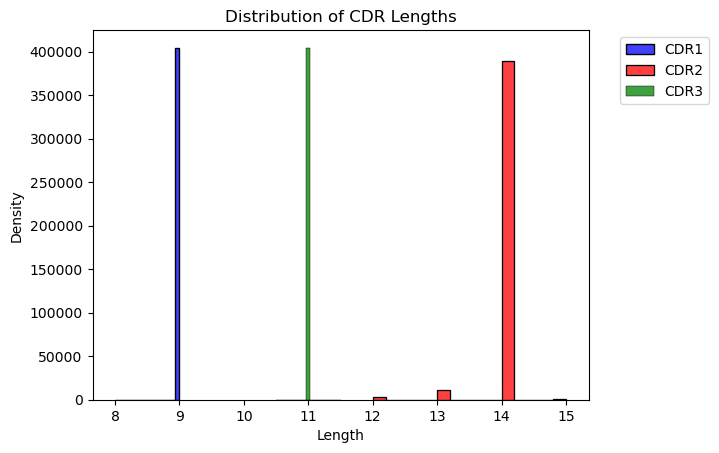

In [14]:
import seaborn as sns

# Assuming df1, df2, df3 are DataFrames for each CDR
# and 'length' is the column in these DataFrames that represents the length

sns.histplot(df['CDR1 Length'], bins=15, color='blue', label='CDR1')
sns.histplot(df['CDR2 Length'], bins=15, color='red', label='CDR2')
sns.histplot(df['CDR3 Length'], bins=15, color='green', label='CDR3')


plt.title('Distribution of CDR Lengths')
plt.xlabel('Length of CDR')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Calculating Lev Distances for CDR1
Completed
Calculating Lev Distances for CDR2
Completed
Calculating Lev Distances for CDR3
Completed


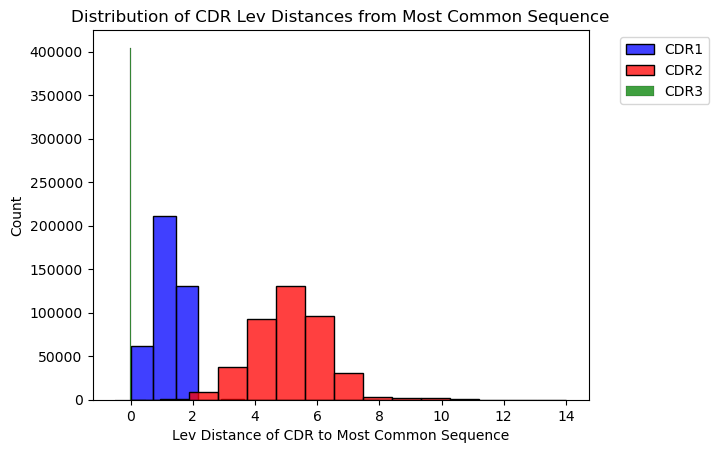

In [33]:
from Levenshtein import distance

# Assuming df is your DataFrame and 'CDR' is the column with the sequences
print("Calculating Lev Distances for CDR1")
# Step 1: Calculate Levenshtein distance for unique sequences
unique_sequences = df['CDR1 Seq'].unique()
most_common_sequence = df['CDR1 Seq'].value_counts().idxmax()

lev_distances = {seq: distance(most_common_sequence, seq) for seq in unique_sequences}

# Step 2: Map distances back to all sequences
df['CDR1 Distance'] = df['CDR1 Seq'].map(lev_distances)
print("Completed")
print("Calculating Lev Distances for CDR2")
# Step 1: Calculate Levenshtein distance for unique sequences
unique_sequences = df['CDR2 Seq'].unique()
most_common_sequence = df['CDR2 Seq'].value_counts().idxmax()

lev_distances = {seq: distance(most_common_sequence, seq) for seq in unique_sequences}

# Step 2: Map distances back to all sequences
df['CDR2 Distance'] = df['CDR2 Seq'].map(lev_distances)
print("Completed")
print("Calculating Lev Distances for CDR3")
# Step 1: Calculate Levenshtein distance for unique sequences
unique_sequences = df['CDR3 Seq'].unique()
most_common_sequence = df['CDR3 Seq'].value_counts().idxmax()

lev_distances = {seq: distance(most_common_sequence, seq) for seq in unique_sequences}

# Step 2: Map distances back to all sequences
df['CDR3 Distance'] = df['CDR3 Seq'].map(lev_distances)
print("Completed")
import seaborn as sns

# Assuming df1, df2, df3 are DataFrames for each CDR
# and 'length' is the column in these DataFrames that represents the length

sns.histplot(df['CDR1 Distance'], bins=11, color='blue', label='CDR1')
sns.histplot(df['CDR2 Distance'], bins=15, color='red', label='CDR2')
sns.histplot(df['CDR3 Distance'], bins=19, color='green', label='CDR3')


plt.title('Distribution of CDR Lev Distances from Most Common Sequence')
plt.xlabel('Lev Distance of CDR to Most Common Sequence')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [43]:
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import CountVectorizer
print("Vectorizing CDR sequences")
# Step 1: Convert sequences into k-mer frequency vectors
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2))  # 2-mer frequencies
unique_sequences = df['CDR1 Seq'].unique()
X = vectorizer.fit_transform(unique_sequences)
print("Performing DBscan Clustering")
# Step 2: Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X)
print("Completed Clustering")
# Step 3: Create a dictionary mapping sequences to cluster labels
print("Mapping back to df")
seq_cluster_dict = {seq: label for seq, label in zip(unique_sequences, dbscan.labels_)}

# Map cluster labels back to original DataFrame
df['CDR1 Cluster'] = df['CDR1 Seq'].map(seq_cluster_dict)
print("clustering Done")


unique_sequences = df['CDR2 Seq']
X = vectorizer.fit_transform(unique_sequences)
print("Performing DBscan Clustering on CDR2")
# Step 2: Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X)
print("Completed Clustering on CDR2")
# Step 3: Create a dictionary mapping sequences to cluster labels
print("Mapping back to df")
seq_cluster_dict = {seq: label for seq, label in zip(unique_sequences, dbscan.labels_)}
# Map cluster labels back to original DataFrame
df['CDR2 Cluster'] = df['CDR2 Seq'].map(seq_cluster_dict)
print("clustering Done")


unique_sequences = df['CDR3 Seq'].unique()
X = vectorizer.fit_transform(unique_sequences)
print("Performing DBscan Clustering on CDR3")
# Step 2: Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X)
print("Completed Clustering on CDR3")
# Step 3: Create a dictionary mapping sequences to cluster labels
print("Mapping back to df")
seq_cluster_dict = {seq: label for seq, label in zip(unique_sequences, dbscan.labels_)}
# Map cluster labels back to original DataFrame
df['CDR3 Cluster'] = df['CDR3 Seq'].map(seq_cluster_dict)
print("clustering Done")





print(df)
sns.histplot(df['CDR1 Cluster'], bins=10, color='blue', label='CDR1')
sns.histplot(df['CDR2 Cluster'], bins=10, color='red', label='CDR2')
sns.histplot(df['CDR3 Cluster'], bins=10, color='green', label='CDR3')
plt.title('Distribution of Cluster Assignments')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Vectorizing CDR sequences
Performing DBscan Clustering
Completed Clustering
Mapping back to df
clustering Done
Performing DBscan Clustering on CDR2


KeyboardInterrupt: 

In [35]:
# Create a new DBSCAN object
dbscan = DBSCAN(eps=0.5, min_samples=5)
print("Clustering Initialized")
# Loop over cdrs
for cdr in cdr_positions.keys():
    # Reshape the data to 2D (necessary for the fit method)
    distances = df[f'{cdr} Distance'].values.reshape(-1, 1)
    print("Fitting ",cdr)
    # Fit the model
    dbscan.fit(distances)
    print("Fitting ",cdr," Completed")
    # Assign the labels (cluster IDs) to a new column in the DataFrame
    print("Adding cluster labels to df")
    df[f'{cdr} Cluster'] = dbscan.labels_
    print("Labels added for ",cdr)
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

# Define cdrs
cdrs = ['CDR1', 'CDR2', 'CDR3']

# Loop over cdrs
for cdr in cdrs:
    # Group sequences by cluster
    groups = df.groupby(f'{cdr} Cluster')
    for cluster, group in groups:
        # Group sequences by length
        length_groups = group.groupby(group[f'{cdr} Seq'].str.len())
        for length, length_group in length_groups:
            # Create a list of SeqRecord objects
            seq_records = []
            for i, seq in enumerate(length_group[f'{cdr} Seq']):
                seq_record = SeqRecord(Seq(seq), id=f'seq{i+1}')
                seq_records.append(seq_record)

            # Align the sequences
            alignment = MultipleSeqAlignment(seq_records)

            # Write the aligned sequences to a file in FASTA format
            with open(f'Clusters/{cdr}_alignment_{cluster}_length_{length}.fa', 'w') as f:
                SeqIO.write(alignment, f, 'fasta')
    print(f"{cdr} Cluster sequence alignment completed")
#for outputting every logo in the folder
import os
import logomaker
from Bio import AlignIO
directory = "Clusters"
logos_folder = "Logos"
if not os.path.exists(logos_folder):
    os.makedirs(logos_folder)

# Get a list of .fa files in the directory
fa_files = [file for file in os.listdir(directory) if file.startswith("CDR") and file.endswith(".fa")]

# Process each .fa file
for fa_file in fa_files:
    # Extract the varying part of the file name
    varying_part = fa_file[len("cdr1_alignment_"):-len(".fa")]

    # Read in the alignment file in FASTA format
    alignment = AlignIO.read(os.path.join(directory, fa_file), "fasta")

    # Convert the alignment to a list of sequences
    sequences = [str(record.seq) for record in alignment]

    # Convert the sequences to a pandas dataframe
    alignment_df = logomaker.alignment_to_matrix(sequences)

    # Create the sequence logo
    logo = logomaker.Logo(alignment_df, color_scheme='dmslogo_funcgroup')
    # Customize the logo appearance
    logo.style_spines(visible=False)
    logo.ax.xaxis.set_tick_params(labelsize=8, which='major', pad=0)
    logo.ax.xaxis.set_tick_params(labelsize=0, which='minor', pad=0)
    logo.ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    logo.ax.set_title(fa_file, fontsize=18)


    # Generate the output file name based on the varying part of the input file name
    output_file = os.path.join(logos_folder, f"{fa_file}_logo.png")

    # Save the figure as a PNG file
    logo_fig = logo.fig
    logo_fig.savefig(output_file, dpi=300)

Clustering Initialized
Fitting  CDR1


MemoryError: 

In [40]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

# Define cdrs
cdrs = ['CDR1', 'CDR2', 'CDR3']

# Loop over cdrs
for cdr in cdrs:
    # Group sequences by cluster
    groups = df.groupby(f'{cdr} Cluster')
    for cluster, group in groups:
        # Group sequences by length
        length_groups = group.groupby(group[f'{cdr} Seq'].str.len())
        for length, length_group in length_groups:
            # Create a list of SeqRecord objects
            seq_records = []
            for i, seq in enumerate(length_group[f'{cdr} Seq']):
                seq_record = SeqRecord(Seq(seq), id=f'seq{i+1}')
                seq_records.append(seq_record)

            # Align the sequences
            alignment = MultipleSeqAlignment(seq_records)

            # Write the aligned sequences to a file in FASTA format
            with open(f'Clusters/{cdr}_alignment_{cluster}_length_{length}.fa', 'w') as f:
                SeqIO.write(alignment, f, 'fasta')
    print(f"{cdr} Cluster sequence alignment completed")
#for outputting every logo in the folder
import os
import logomaker
from Bio import AlignIO
directory = "Clusters"
logos_folder = "Logos"
if not os.path.exists(logos_folder):
    os.makedirs(logos_folder)

# Get a list of .fa files in the directory
fa_files = [file for file in os.listdir(directory) if file.startswith("CDR") and file.endswith(".fa")]

# Process each .fa file
for fa_file in fa_files:
    # Extract the varying part of the file name
    varying_part = fa_file[len("cdr1_alignment_"):-len(".fa")]

    # Read in the alignment file in FASTA format
    alignment = AlignIO.read(os.path.join(directory, fa_file), "fasta")

    # Convert the alignment to a list of sequences
    sequences = [str(record.seq) for record in alignment]

    # Convert the sequences to a pandas dataframe
    alignment_df = logomaker.alignment_to_matrix(sequences)

    # Create the sequence logo
    logo = logomaker.Logo(alignment_df, color_scheme='dmslogo_funcgroup')
    # Customize the logo appearance
    logo.style_spines(visible=False)
    logo.ax.xaxis.set_tick_params(labelsize=8, which='major', pad=0)
    logo.ax.xaxis.set_tick_params(labelsize=0, which='minor', pad=0)
    logo.ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    logo.ax.set_title(fa_file, fontsize=18)


    # Generate the output file name based on the varying part of the input file name
    output_file = os.path.join(logos_folder, f"{fa_file}_logo.png")

    # Save the figure as a PNG file
    logo_fig = logo.fig
    logo_fig.savefig(output_file, dpi=300)

CDR1 Cluster sequence alignment completed


KeyError: 'CDR2 Cluster'

<built-in method keys of dict object at 0x0000024FA0BADB88>
